## Importing important libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import RobertaTokenizer
import numpy as np
from transformers import TFRobertaForSequenceClassification, RobertaConfig
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

2024-03-25 22:00:16.135687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 22:00:16.135761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 22:00:16.138001: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 22:00:16.147179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Hyperparameters 

Easy and straightforward hyperparameter tuning

In [3]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
EPOCHS = 6
TEST_SIZE = 0.2
RANDOM_STATE = 42
MAX_LEN = 128  # Maximum sequence length
NUM_LABELS = 6

## F1 Metric

In [4]:
def f1_metric(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Setup and Data Preparation

Loading the dataset, preprocessing the text, and preparing the data for the model.

In [5]:
# Specify the path to your CSV file
file_path = 'Tasks/emotion_data_merged_4.csv'

# Load the dataset
dataset = pd.read_csv(file_path)

dataset = dataset.dropna(subset=['emotion']).query("emotion != 'neutral'")
data = dataset.drop_duplicates()

# Shuffle the combined dataset
data = data.sample(frac=1).reset_index(drop=True)

# Display basic information about the combined dataset
print("Preview of the dataset:")
print(data.head())

print("\nSummary statistics of the  dataset:")
print(data.describe())

print("\nInformation about columns in the dataset:")
print(data.info())

sentences = data['sentence'].values
labels = data['emotion'].values

Preview of the dataset:
                                            sentence    emotion
0                       i feel even mildly resentful      anger
1   You're right . That might seem a bit rude . I...  happiness
2  i sat up every night thinking about and when i...  happiness
3  i can imagine there are a lot of scared women ...    sadness
4  i feel this aching every time i think of you w...    sadness

Summary statistics of the  dataset:
                            sentence    emotion
count                         479140     479140
unique                        479140          6
top     i feel even mildly resentful  happiness
freq                               1     190250

Information about columns in the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479140 entries, 0 to 479139
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  479140 non-null  object
 1   emotion   479140 non-null  object
dtypes

In [6]:
# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

# Tokenize sentences to get input IDs and attention masks
max_len = 128  # or choose a different max length
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens=True,
                        max_length=max_len,
                        truncation=True,
                        padding='max_length',
                        return_attention_mask=True,
                        return_tensors='tf',
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert lists to tensors
input_ids = tf.concat(input_ids, axis=0)
attention_masks = tf.concat(attention_masks, axis=0)


2024-03-25 22:00:22.359670: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-03-25 22:00:22.360012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 40228 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


In [7]:
# Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels = tf.convert_to_tensor(labels)

In [8]:
# Ensure all inputs to train_test_split are numpy arrays
input_ids_np = input_ids.numpy() if isinstance(input_ids, tf.Tensor) else input_ids
attention_masks_np = attention_masks.numpy() if isinstance(attention_masks, tf.Tensor) else attention_masks
labels_np = labels.numpy() if isinstance(labels, tf.Tensor) else labels

# Now perform the train-test split
X_train, X_val, y_train, y_val = train_test_split(input_ids_np, labels_np, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=labels_np)
train_mask, val_mask = train_test_split(attention_masks_np, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=labels_np)

# Convert numpy arrays back to tensors for TensorFlow compatibility
X_train = tf.constant(X_train)
X_val = tf.constant(X_val)
y_train = tf.constant(y_train)
y_val = tf.constant(y_val)
train_mask = tf.constant(train_mask)
val_mask = tf.constant(val_mask)

In [9]:
# Create TensorFlow datasets for the training and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": X_train, "attention_mask": train_mask}, y_train)).shuffle(len(X_train)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": X_val, "attention_mask": val_mask}, y_val)).batch(BATCH_SIZE)

## Model training

Setting up the RoBERTa model, defining the training loop, and initiating the training process.

In [10]:
# Load RoBERTa model
model_config = RobertaConfig.from_pretrained('roberta-large', num_labels=NUM_LABELS)
model = TFRobertaForSequenceClassification.from_pretrained('roberta-large', config=model_config)
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', f1_metric])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [11]:
history = model.fit(train_dataset, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_dataset)


Epoch 1/6


2024-03-25 22:08:02.627392: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcfced76990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-25 22:08:02.627430: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-03-25 22:08:02.636949: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-25 22:08:02.671933: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1711404482.794048  346832 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5990/5990 [==============================] - 8008s 1s/step - loss: 0.1271 - accuracy: 0.9566 - f1_metric: 1.0935 - val_loss: 0.0754 - val_accuracy: 0.9747 - val_f1_metric: 0.9913
Epoch 2/6
5990/5990 [==============================] - 7877s 1s/step - loss: 0.0689 - accuracy: 0.9760 - f1_metric: 1.0310 - val_loss: 0.0671 - val_accuracy: 0.9764 - val_f1_metric: 0.9966
Epoch 3/6
5990/5990 [==============================] - 7880s 1s/step - loss: 0.0551 - accuracy: 0.9806 - f1_metric: 1.0176 - val_loss: 0.0710 - val_accuracy: 0.9764 - val_f1_metric: 0.9875
Epoch 4/6
5990/5990 [==============================] - 7956s 1s/step - loss: 0.0439 - accuracy: 0.9844 - f1_metric: 1.0113 - val_loss: 0.0710 - val_accuracy: 0.9770 - val_f1_metric: 0.9804
Epoch 5/6
5990/5990 [==============================] - 7897s 1s/step - loss: 0.0343 - accuracy: 0.9878 - f1_metric: 0.9957 - val_loss: 0.0812 - val_accuracy: 0.9770 - val_f1_metric: 0.9822
Epoch 6/6
5990/5990 [==============================] - 9024s 2s/s

In [24]:
results = model.evaluate(val_dataset)
print(f"Validation loss: {results[0]}, Validation accuracy: {results[1]}, Validation F1 Score: {results[2]}")

1498/1498 [==============================] - 652s 435ms/step - loss: 0.0867 - accuracy: 0.9771 - f1_metric: 0.9744
Validation loss: 0.08672452718019485, Validation accuracy: 0.9770630598068237, Validation F1 Score: 0.9744131565093994


## Visualization

Generate usefull insights on the training

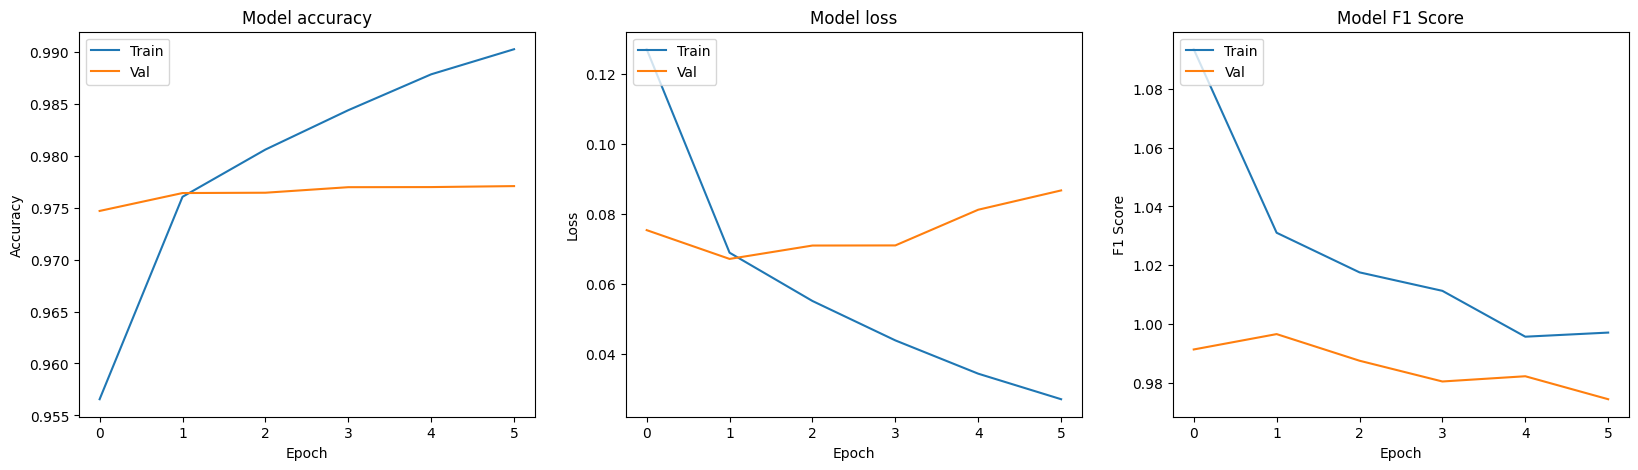

In [22]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    # Plot training & validation accuracy values
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Val'], loc='upper left')
    
    # Plot training & validation F1 score values
    ax[2].plot(history.history['f1_metric'])
    ax[2].plot(history.history['val_f1_metric'])
    ax[2].set_title('Model F1 Score')
    ax[2].set_ylabel('F1 Score')
    ax[2].set_xlabel('Epoch')
    ax[2].legend(['Train', 'Val'], loc='upper left')

    plt.show()

plot_training_history(history)


##  Generate the Confusion Matrix and Metrics

With the true labels and predictions, we can now generate a confusion matrix and calculate other evaluation metrics like precision, recall, and F1-score.

2995/2995 [==============================] - 852s 284ms/step


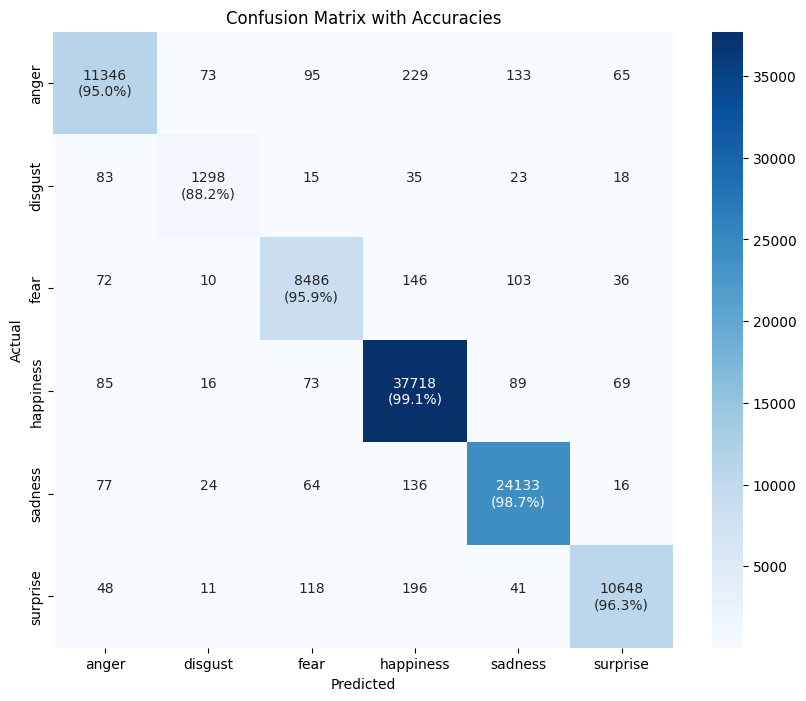

In [25]:
# Assuming X_val and y_val are your test inputs and labels, respectively.
# If you have a separate test set, replace X_val and y_val accordingly.

# Predict classes with the model
predictions = model.predict({"input_ids": X_val, "attention_mask": val_mask})
predicted_labels = np.argmax(predictions.logits, axis=1)

# Since your labels are already encoded with LabelEncoder, there's no need to decode them

# Generate the confusion matrix
cm = confusion_matrix(y_val, predicted_labels)

# Calculate per-class accuracies
accuracies = cm.diagonal() / cm.sum(axis=1)

# Create an annotated confusion matrix with accuracies
cm_with_acc = cm.astype('str')  # Convert counts to string for annotation
for i in range(len(cm)):
    for j in range(len(cm[i])):
        # Append accuracy to the diagonal elements
        if i == j:
            cm_with_acc[i][j] = f"{cm[i][j]}\n({accuracies[i]*100:.1f}%)"
        else:
            cm_with_acc[i][j] += "\n "

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=cm_with_acc, fmt='', ax=ax, cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix with Accuracies')
plt.show()


## Prepare the Submission DataFrame and Save

In [26]:
# Load the test dataset
test_df = pd.read_csv('test (1).csv', sep='\t')

# Assuming 'sentence' is your column of interest and tokenizer is already defined
# Prepare the test sentences with RobertaTokenizer
test_input_ids = []
test_attention_masks = []

for sent in test_df['sentence']:
    encoded_dict = tokenizer.encode_plus(
                        sent,                        # Sentence to encode
                        add_special_tokens = True,   # Add '[CLS]' and '[SEP]'
                        max_length = 128,            # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,# Construct attention masks
                        return_tensors = 'tf',       # Return tf tensors
                   )
    
    # Add the encoded sentence to the list
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

# Convert lists into tensors
test_input_ids = tf.concat(test_input_ids, axis=0)
test_attention_masks = tf.concat(test_attention_masks, axis=0)

# Make predictions using the trained model
predictions = model.predict({"input_ids": test_input_ids, "attention_mask": test_attention_masks})
predicted_labels = np.argmax(predictions.logits, axis=1)

# Convert numeric predictions back to original labels using the LabelEncoder
predicted_emotions = label_encoder.inverse_transform(predicted_labels)

# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],  # Assuming there's an 'id' column in your test set
    'emotion': predicted_emotions
})

# Save the submission file
submission_df.to_csv('Roberta_V6_task12.csv', index=False, sep=',')



/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


45/45 [==============================] - 11s 242ms/step


In [17]:
import joblib

# Define the base path for saving
base_save_path = "Roberta_V6_task12"

# Specify the paths for the model, tokenizer, and label encoder
model_save_path = f"{base_save_path}/model"
tokenizer_save_path = f"{base_save_path}/tokenizer"
label_encoder_save_path = f"{base_save_path}/label_encoder.joblib"

# Assuming `model` is your TFRobertaForSequenceClassification model,
# `tokenizer` is your RobertaTokenizer, and `label_encoder` is your LabelEncoder instance

# Save the model
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

# Save the label encoder
joblib.dump(label_encoder, label_encoder_save_path)

['Roberta_V6_task12/label_encoder.joblib']